## ATAC + MULTIOME (males april 2021)

### Build anndata from cellatac output 

In [2]:
# Load libraries
import pandas as pd 
import scanpy as sc
import numpy as np
import scipy.sparse

In [3]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/males_apr2021/"
experiment_prefix = 'males_'
cellatac_outdir = '/lustre/scratch117/cellgen/cellgeni/TIC-atacseq/tic-1004/male/results200k-b-male/'


In [4]:
input={'cnts': cellatac_outdir + 'peak_matrix/peaks_bc_matrix.mmtx.gz',
        "bcs": cellatac_outdir + 'peak_matrix/bc.txt',
      "peaks": cellatac_outdir + 'peak_matrix/peaks.txt',
      'clusters': cellatac_outdir + 'qc/seurat-clades.tsv'}

output = {
    "cnt_mmtx":outdir + experiment_prefix + '_ATAC_cisTopic.mmtx',
    "cnt_peaks":outdir + experiment_prefix + '_ATAC_cisTopic.peaks.tsv',
    "cnt_cells":outdir + experiment_prefix + '_ATAC_cisTopic.cells.tsv',
    "h5ad":outdir + experiment_prefix + '_ATAC_raw.h5ad',
}

#### Make anndata object

In [5]:
adata = sc.read_mtx(input["cnts"]).T

bc = pd.read_table(input["bcs"], header=None)
feat = pd.read_table(input["peaks"], header=None)

adata.obs_names = bc[0]
adata.var_names = feat[0]

In [6]:
adata

AnnData object with n_obs × n_vars = 31481 × 447835

#### Match cellatac code to sample

In [7]:
# Code from cell barcodes 
adata.obs['code'] = [name[0:2] for name in adata.obs_names]
adata.obs['code'].value_counts(dropna = False)

04    8513
07    5427
06    5335
05    4628
02    2872
09    1461
08    1415
01    1111
03     719
Name: code, dtype: int64

In [8]:
# Sample from code 
sample_dictionary = {'01' : 'FCA_GND8768481', '02' : 'FCA_GND8768482', '03' : 'FCA_GND8768487',
                    '04' : 'FCA_GND8795927', '05' : 'FCA_GND8795928', '06' : 'HD_F_GON9479872', 
                    '07' : 'FCA_GND9332157', '08' : 'HD_F_GON9525611', '09' : 'HD_F_GON9525612'}
adata.obs['sample'] = adata.obs['code'].map(sample_dictionary) 
adata.obs['sample'].value_counts(dropna = False)

FCA_GND8795927     8513
FCA_GND9332157     5427
HD_F_GON9479872    5335
FCA_GND8795928     4628
FCA_GND8768482     2872
HD_F_GON9525612    1461
HD_F_GON9525611    1415
FCA_GND8768481     1111
FCA_GND8768487      719
Name: sample, dtype: int64

#### Load peak annotations (done with R script by Emma)

In [9]:
peak_anno_df = pd.read_csv(outdir + "ATACpeaks_annotation.csv", index_col = 0)
peak_anno_df.index = peak_anno_df["peak_id"]
peak_anno_df.drop("peak_id",1, inplace = True)
adata.var = pd.concat([adata.var, peak_anno_df], 1)
adata

AnnData object with n_obs × n_vars = 31481 × 447835
    obs: 'code', 'sample'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist'

#### Save binary data to layers

In [10]:
adata.layers["binary_raw"] = adata.X
adata.layers["binary_raw"][adata.layers["binary_raw"] > 1] = 1
adata

AnnData object with n_obs × n_vars = 31481 × 447835
    obs: 'code', 'sample'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist'
    layers: 'binary_raw'

#### Peak filtering

array([[<AxesSubplot:title={'center':'peak_width'}>]], dtype=object)

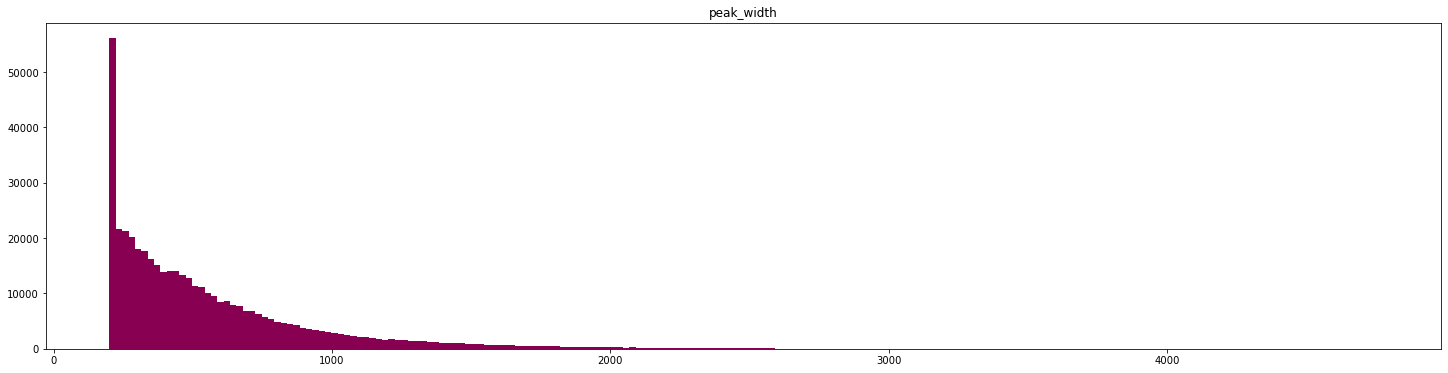

In [11]:
adata.var.hist(column = 'peak_width', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [12]:
var_qc = sc.pp.calculate_qc_metrics(adata, layer = "binary_raw")[1]
adata.var = pd.concat([adata.var, var_qc], 1)
adata

/opt/conda/envs/atac_env/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:316: UserWarning: Could not obtain multiprocessing lock due to OS level error: [Errno 28] No space left on device
A likely cause of this problem is '/dev/shm' is missing orread-only such that necessary semaphores cannot be written.
*** The responsibility of ensuring multiprocessing safe access to this initialization sequence/module import is deferred to the user! ***

  warnings.warn(msg % str(e))


AnnData object with n_obs × n_vars = 31481 × 447835
    obs: 'code', 'sample'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [13]:
adata.var.head()

,peak_width,exon,gene,promoter,annotation,gene_name,gene_id,tss_distance,ENCODE_blacklist,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
chr1:10003-10421,419,0,0,0,intergenic,NaN,NaN,58669,1,265,0.008418,0.008383,99.158222,265.0,5.583496
chr1:180688-181626,939,0,0,1,promoter,FO538757.2,ENSG00000279928,766,1,970,0.030812,0.030347,96.918776,970.0,6.878326
chr1:191310-191630,321,0,1,0,intron,FO538757.1,ENSG00000279457,3780,1,234,0.007433,0.007406,99.256695,234.0,5.459586
chr1:267866-268092,227,0,0,0,intergenic,NaN,NaN,67543,1,306,0.009720,0.009673,99.027985,306.0,5.726848
chr1:586071-586290,220,0,0,0,intergenic,NaN,NaN,100363,1,280,0.008894,0.008855,99.110575,280.0,5.638355


array([[<AxesSubplot:title={'center':'total_counts'}>]], dtype=object)

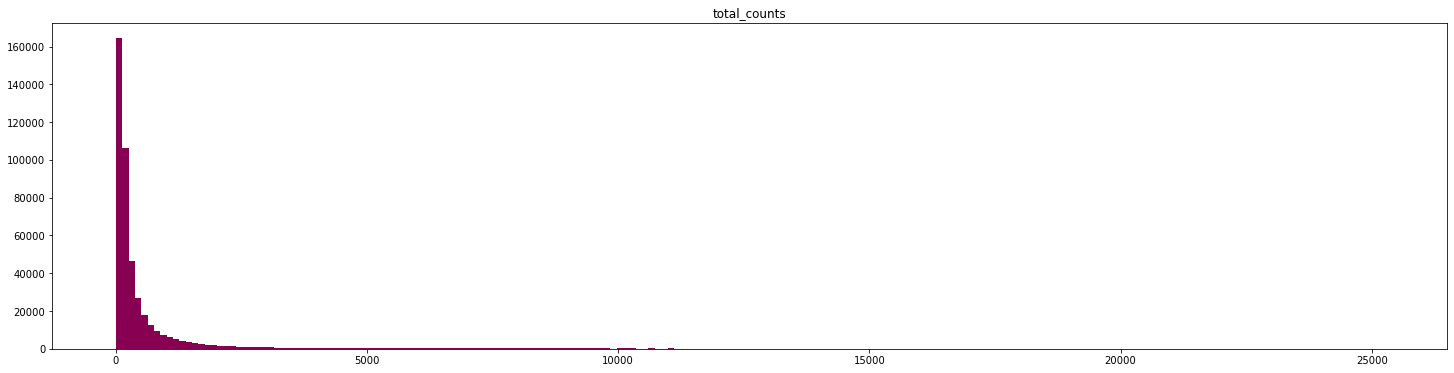

In [14]:
adata.var.hist(column = 'total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [15]:
thirty_percent = len(adata.obs_names) / 100 * 30
point_two_percent = len(adata.obs_names) / 100 * 0.2
print("30% : {}".format(thirty_percent))
print("0.2% : {}".format(point_two_percent))

30% : 9444.3
0.2% : 62.962


In [16]:
# Accessible in at least k cells
adata = adata[:,adata.var.total_counts > point_two_percent]
adata = adata[:,adata.var.total_counts < thirty_percent]
adata

View of AnnData object with n_obs × n_vars = 31481 × 400285
    obs: 'code', 'sample'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [17]:
# Remove peaks in ENCODE blacklist
adata = adata[:, adata.var.ENCODE_blacklist == 0]
adata

View of AnnData object with n_obs × n_vars = 31481 × 398815
    obs: 'code', 'sample'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [18]:
# Filter by width (remove peaks at the lowest end, closest to min peak width in MACS2)

adata = adata[:, adata.var.peak_width > 210]
adata = adata[:, adata.var.peak_width < 1500]
adata

View of AnnData object with n_obs × n_vars = 31481 × 361243
    obs: 'code', 'sample'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [19]:
adata.var.head()

,peak_width,exon,gene,promoter,annotation,gene_name,gene_id,tss_distance,ENCODE_blacklist,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
chr1:816745-817435,691,0,0,0,intergenic,NaN,NaN,106492,0,565,0.017947,0.017788,98.205267,565.0,6.338594
chr1:817739-818227,489,0,0,0,intergenic,NaN,NaN,105700,0,200,0.006353,0.006333,99.364696,200.0,5.303305
chr1:825790-826042,253,0,0,0,intergenic,NaN,NaN,97885,0,277,0.008799,0.008760,99.120104,277.0,5.627621
chr1:826603-827799,1197,0,0,0,intergenic,NaN,NaN,96128,0,5105,0.162161,0.150281,83.783870,5105.0,8.538172
chr1:842634-843206,573,0,0,0,intergenic,NaN,NaN,80721,0,188,0.005972,0.005954,99.402814,188.0,5.241747


In [20]:
adata.var['annotation'].value_counts()

intergenic    162638
intron        148148
exon           38972
promoter       11485
Name: annotation, dtype: int64

In [21]:
### Filter peaks that are not accessible in at least 4% of cells from a coarse cluster
min_frac=0.04
# Load cluster information from cellatac outputs
clusters = pd.read_table(input["clusters"], header = None, index_col = 0)
clusters.columns = ["cellatac_clusters"]
adata.obs = clusters.loc[adata.obs_names]
adata

AnnData object with n_obs × n_vars = 31481 × 361243
    obs: 'cellatac_clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [22]:
n_clusters = len(np.unique(adata.obs[["cellatac_clusters"]]))
clus_mat = np.empty([adata.n_obs, n_clusters])
for cl in np.unique(adata.obs[["cellatac_clusters"]]):
    clus_mat[np.where(adata.obs['cellatac_clusters']==cl)[0],cl] = 1

clus_mat = scipy.sparse.csr_matrix(clus_mat)
clus_mat[clus_mat != 1 ] = 0

/opt/conda/envs/atac_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3427: SparseEfficiencyWarning: Comparing a sparse matrix with a nonzero scalar using != is inefficient, try using == instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/envs/atac_env/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [23]:
cl_peak_mat = np.dot(clus_mat.T, adata.layers["binary_raw"])

In [24]:
cl_peak_frac = cl_peak_mat/clus_mat.sum(0).T

In [25]:
bool_matrix = cl_peak_frac.max(0) > min_frac
bool_matrix.shape

(1, 361243)

In [26]:
bool_vector = np.squeeze(np.asarray(bool_matrix))
bool_vector.shape

(361243,)

In [27]:
adata = adata[:, bool_vector]

In [28]:
adata

View of AnnData object with n_obs × n_vars = 31481 × 232562
    obs: 'cellatac_clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

#### Filter low quality cells

In [29]:
sc.pp.calculate_qc_metrics(adata, layer = "binary_raw", inplace = True)

Trying to set attribute `.obs` of view, copying.


array([[<AxesSubplot:title={'center':'log1p_total_counts'}>]],
      dtype=object)

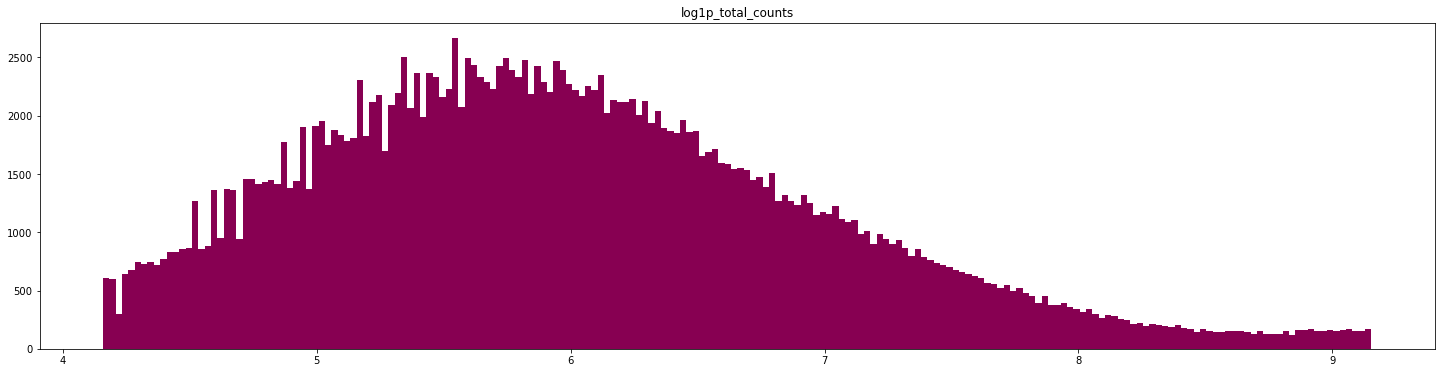

In [30]:
adata.var.hist(column = 'log1p_total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

array([[<AxesSubplot:title={'center':'log1p_total_counts'}>]],
      dtype=object)

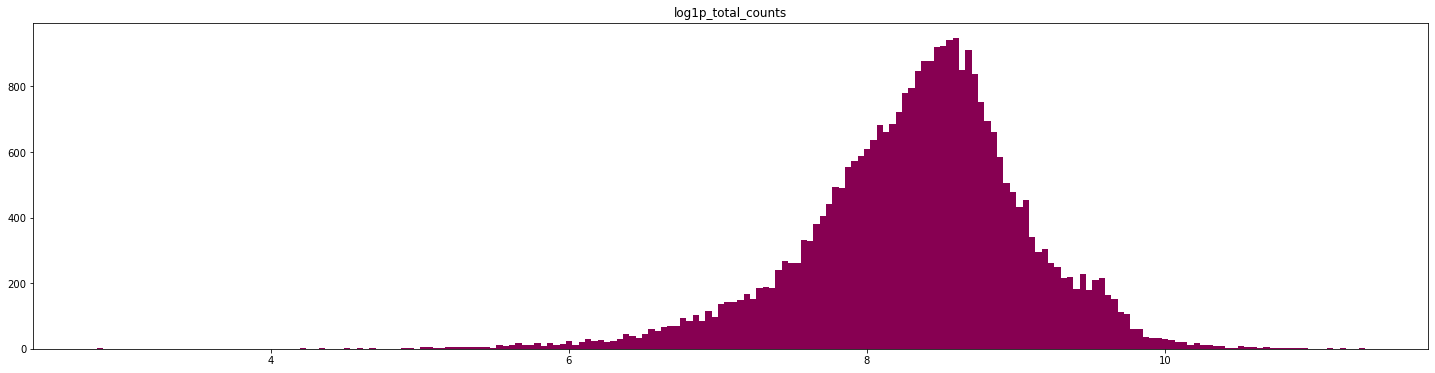

In [31]:
adata.obs.hist(column = 'log1p_total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [32]:
adata = adata[adata.obs.log1p_total_counts >= 6]
adata

View of AnnData object with n_obs × n_vars = 31261 × 232562
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [33]:
## Write output anndata
adata.write_h5ad(output["h5ad"])

/opt/conda/envs/atac_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.var` of view, copying.
... storing 'annotation' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'gene_name' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'gene_id' as categorical


#### End of notebook